In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/TwitterSentimentProject')

print("✅ Setup complete!")

Mounted at /content/drive
✅ Setup complete!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse import load_npz
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("✅ Libraries imported!")

✅ Libraries imported!


In [3]:
# Load data from Person 2
df = pd.read_csv('data/processed/tweets_with_features_person2.csv')

print(f"Dataset loaded: {len(df):,} rows")
print(f"\nColumns: {list(df.columns)}")

# Load TF-IDF matrix
X_tfidf = load_npz('data/processed/X_tfidf.npz')
print(f"\n✅ TF-IDF matrix loaded: {X_tfidf.shape}")

# Load Count matrix
X_count = load_npz('data/processed/X_count.npz')
print(f"✅ Count matrix loaded: {X_count.shape}")

# Get labels
y = df['sentiment'].values
print(f"✅ Labels loaded: {y.shape}")
print(f"\nClass distribution:")
print(f"Negative: {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")
print(f"Positive: {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")

Dataset loaded: 99,109 rows

Columns: ['sentiment', 'text', 'text_cleaned', 'text_no_stopwords', 'text_lemmatized', 'cleaned_word_count', 'lemmatized_word_count', 'char_count', 'word_count', 'avg_word_length', 'unique_word_count', 'lexical_diversity', 'exclamation_count', 'question_count', 'capital_ratio']

✅ TF-IDF matrix loaded: (99109, 5000)
✅ Count matrix loaded: (99109, 5000)
✅ Labels loaded: (99109,)

Class distribution:
Negative: 49,522 (50.0%)
Positive: 49,587 (50.0%)


In [4]:
# Split data: 70% train, 15% validation, 15% test

print("Splitting data...")

# First split: 70% train, 30% temp
X_train_tfidf, X_temp_tfidf, y_train, y_temp = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (from the 30% temp)
X_val_tfidf, X_test_tfidf, y_val, y_test = train_test_split(
    X_temp_tfidf, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("="*70)
print("DATA SPLIT COMPLETE")
print("="*70)
print(f"\nTrain set: {X_train_tfidf.shape[0]:,} samples ({X_train_tfidf.shape[0]/len(df)*100:.1f}%)")
print(f"  Negative: {(y_train==0).sum():,}")
print(f"  Positive: {(y_train==1).sum():,}")

print(f"\nValidation set: {X_val_tfidf.shape[0]:,} samples ({X_val_tfidf.shape[0]/len(df)*100:.1f}%)")
print(f"  Negative: {(y_val==0).sum():,}")
print(f"  Positive: {(y_val==1).sum():,}")

print(f"\nTest set: {X_test_tfidf.shape[0]:,} samples ({X_test_tfidf.shape[0]/len(df)*100:.1f}%)")
print(f"  Negative: {(y_test==0).sum():,}")
print(f"  Positive: {(y_test==1).sum():,}")

Splitting data...
DATA SPLIT COMPLETE

Train set: 69,376 samples (70.0%)
  Negative: 34,665
  Positive: 34,711

Validation set: 14,866 samples (15.0%)
  Negative: 7,428
  Positive: 7,438

Test set: 14,867 samples (15.0%)
  Negative: 7,429
  Positive: 7,438


In [5]:
# Also split the text data (needed for deep learning models)

# Get train, val, test indices
train_indices = df.index[:len(y_train)]
val_indices = df.index[len(y_train):len(y_train)+len(y_val)]
test_indices = df.index[len(y_train)+len(y_val):]

# Split dataframe
df_train = df.iloc[:len(y_train)].copy()
df_val = df.iloc[len(y_train):len(y_train)+len(y_val)].copy()
df_test = df.iloc[len(y_train)+len(y_val):].copy()

# Actually, let's do it properly with train_test_split on the dataframe
from sklearn.model_selection import train_test_split

# First split
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

# Second split
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['sentiment'])

print(f"✅ Text data split:")
print(f"Train: {len(df_train):,}")
print(f"Validation: {len(df_val):,}")
print(f"Test: {len(df_test):,}")

# Extract text for each set
train_texts = df_train['text_lemmatized'].values
val_texts = df_val['text_lemmatized'].values
test_texts = df_test['text_lemmatized'].values

# Extract labels
y_train = df_train['sentiment'].values
y_val = df_val['sentiment'].values
y_test = df_test['sentiment'].values

print(f"\n✅ Ready for deep learning models!")

✅ Text data split:
Train: 69,376
Validation: 14,866
Test: 14,867

✅ Ready for deep learning models!


In [6]:
# Create tokenizer for neural networks

print("Creating tokenizer for deep learning...")

# Initialize tokenizer
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 50       # Maximum sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')

# Fit on training data only
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
X_train_seq = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_seq = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_seq = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"✅ Tokenization complete!")
print(f"\nVocabulary size: {len(tokenizer.word_index):,}")
print(f"Max sequence length: {MAX_LEN}")
print(f"\nPadded sequences:")
print(f"  Train: {X_train_seq.shape}")
print(f"  Validation: {X_val_seq.shape}")
print(f"  Test: {X_test_seq.shape}")

# Show example
print(f"\nExample:")
print(f"Original text: {train_texts[0]}")
print(f"Sequence: {train_sequences[0]}")
print(f"Padded: {X_train_seq[0]}")

Creating tokenizer for deep learning...
✅ Tokenization complete!

Vocabulary size: 46,963
Max sequence length: 50

Padded sequences:
  Train: (69376, 50)
  Validation: (14866, 50)
  Test: (14867, 50)

Example:
Original text: oh dear bnp man try funny
Sequence: [37, 428, 3476, 135, 65, 268]
Padded: [  37  428 3476  135   65  268    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [8]:
# Download and prepare GloVe embeddings
print("Downloading GloVe embeddings...")
print("(This may take 2-3 minutes)\n")

# Download GloVe
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

print("✅ GloVe downloaded!")

# Load GloVe embeddings
EMBEDDING_DIM = 100  # Using 100d GloVe

print(f"\nLoading GloVe {EMBEDDING_DIM}d embeddings...")

embeddings_index = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"✅ Loaded {len(embeddings_index):,} word vectors")

# Create embedding matrix
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"\n✅ Embedding matrix created: {embedding_matrix.shape}")

# Calculate coverage
num_words_found = np.sum(np.sum(embedding_matrix, axis=1) != 0)
coverage = num_words_found / vocab_size * 100
print(f"Coverage: {coverage:.2f}% ({num_words_found:,}/{vocab_size:,} words found in GloVe)")

(This may take 2-3 minutes)

replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
✅ GloVe downloaded!

Loading GloVe 100d embeddings...
✅ Loaded 400,000 word vectors

✅ Embedding matrix created: (10000, 100)
Coverage: 88.57% (8,857/10,000 words found in GloVe)


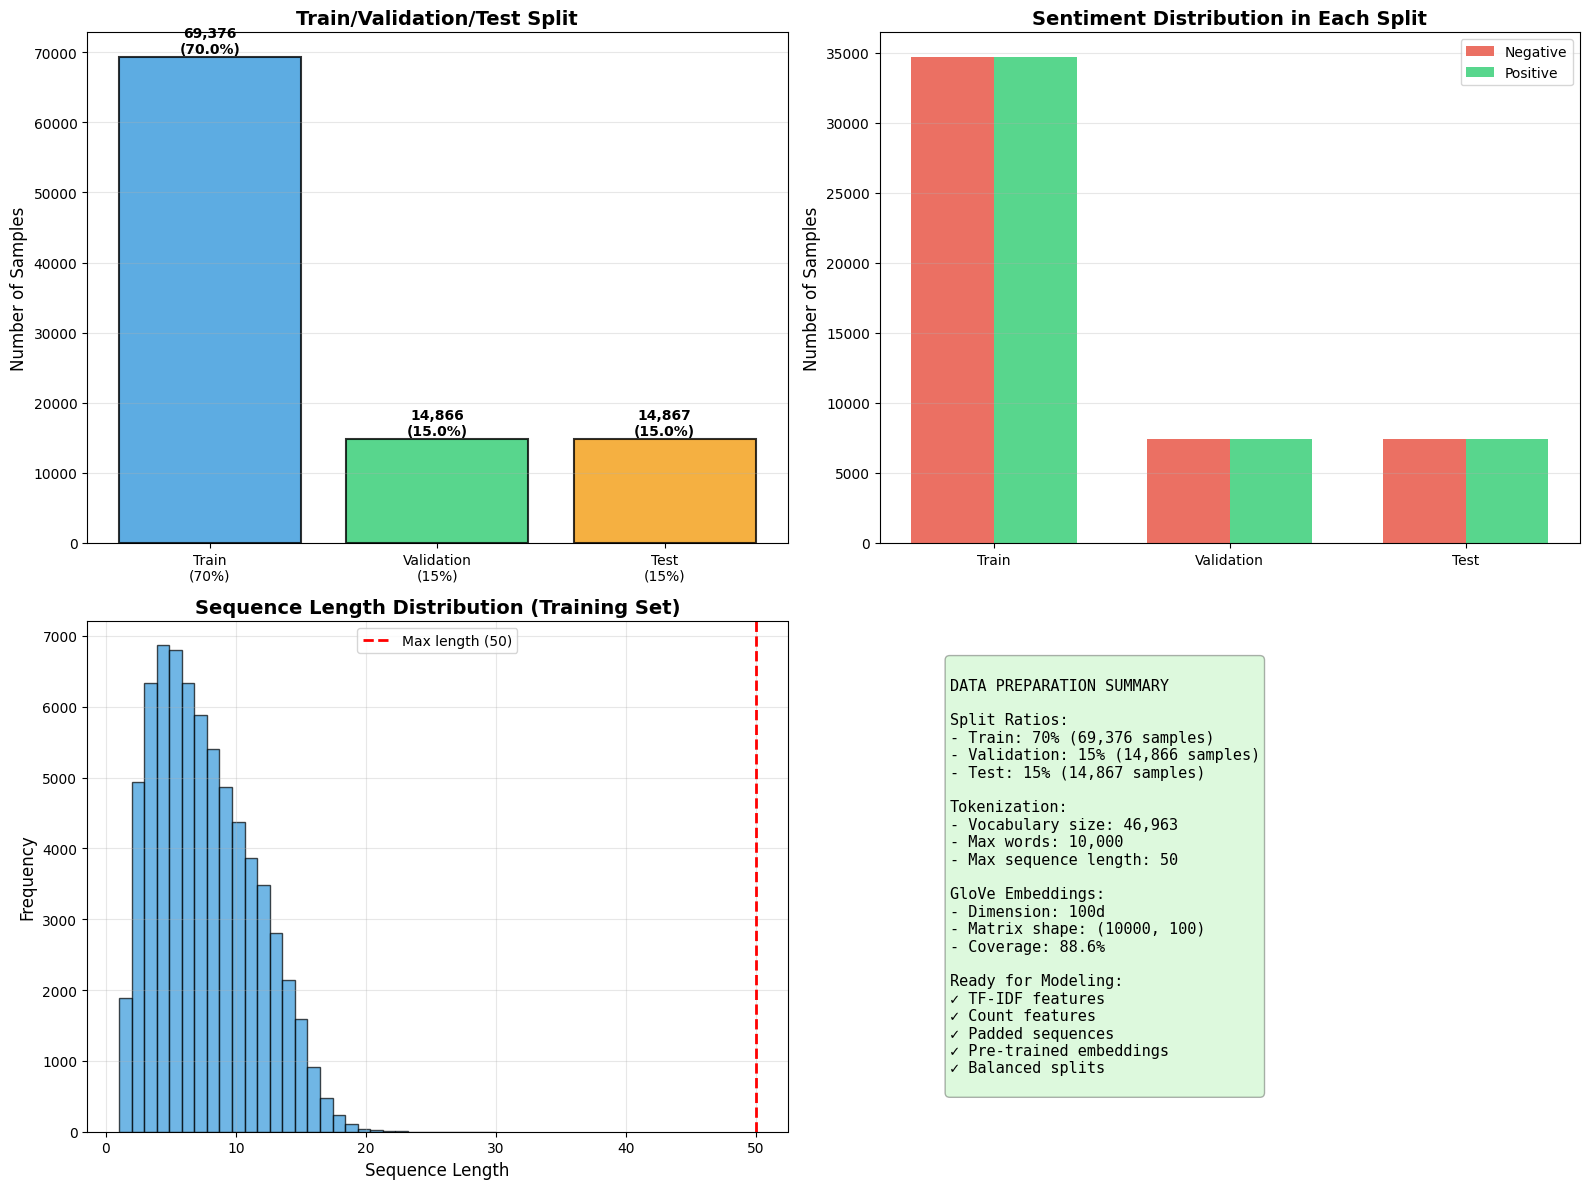

✅ Saved: results/figures/09_person3_data_split.png


In [9]:
# Visualize data splits and statistics

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Data split distribution
split_sizes = [len(y_train), len(y_val), len(y_test)]
split_labels = ['Train\n(70%)', 'Validation\n(15%)', 'Test\n(15%)']
colors = ['#3498db', '#2ecc71', '#f39c12']

axes[0, 0].bar(split_labels, split_sizes, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Number of Samples', fontsize=12)
axes[0, 0].set_title('Train/Validation/Test Split', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(split_sizes):
    axes[0, 0].text(i, v + 500, f'{v:,}\n({v/len(df)*100:.1f}%)',
                    ha='center', fontweight='bold')

# 2. Sentiment distribution in each split
x = np.arange(3)
width = 0.35

neg_counts = [(y_train==0).sum(), (y_val==0).sum(), (y_test==0).sum()]
pos_counts = [(y_train==1).sum(), (y_val==1).sum(), (y_test==1).sum()]

axes[0, 1].bar(x - width/2, neg_counts, width, label='Negative', color='#e74c3c', alpha=0.8)
axes[0, 1].bar(x + width/2, pos_counts, width, label='Positive', color='#2ecc71', alpha=0.8)
axes[0, 1].set_ylabel('Number of Samples', fontsize=12)
axes[0, 1].set_title('Sentiment Distribution in Each Split', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Train', 'Validation', 'Test'])
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Sequence length distribution
axes[1, 0].hist(np.sum(X_train_seq != 0, axis=1), bins=30,
                alpha=0.7, color='#3498db', edgecolor='black')
axes[1, 0].axvline(MAX_LEN, color='red', linestyle='--', linewidth=2, label=f'Max length ({MAX_LEN})')
axes[1, 0].set_xlabel('Sequence Length', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Sequence Length Distribution (Training Set)',
                     fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Summary information
axes[1, 1].axis('off')
summary_text = f"""
DATA PREPARATION SUMMARY

Split Ratios:
- Train: 70% ({len(y_train):,} samples)
- Validation: 15% ({len(y_val):,} samples)
- Test: 15% ({len(y_test):,} samples)

Tokenization:
- Vocabulary size: {len(tokenizer.word_index):,}
- Max words: {MAX_WORDS:,}
- Max sequence length: {MAX_LEN}

GloVe Embeddings:
- Dimension: {EMBEDDING_DIM}d
- Matrix shape: {embedding_matrix.shape}
- Coverage: {coverage:.1f}%

Ready for Modeling:
✓ TF-IDF features
✓ Count features
✓ Padded sequences
✓ Pre-trained embeddings
✓ Balanced splits
"""

axes[1, 1].text(0.1, 0.5, summary_text,
                fontsize=11, family='monospace',
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.savefig('results/figures/09_person3_data_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: results/figures/09_person3_data_split.png")

In [10]:
# Save all split data

print("Saving split data...")

# Save TF-IDF splits
from scipy.sparse import save_npz
save_npz('data/processed/X_train_tfidf.npz', X_train_tfidf)
save_npz('data/processed/X_val_tfidf.npz', X_val_tfidf)
save_npz('data/processed/X_test_tfidf.npz', X_test_tfidf)
print("✅ TF-IDF splits saved")

# Save labels
np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_val.npy', y_val)
np.save('data/processed/y_test.npy', y_test)
print("✅ Labels saved")

# Save sequences for deep learning
np.save('data/processed/X_train_seq.npy', X_train_seq)
np.save('data/processed/X_val_seq.npy', X_val_seq)
np.save('data/processed/X_test_seq.npy', X_test_seq)
print("✅ Sequences saved")

# Save tokenizer
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved")

# Save embedding matrix
np.save('models/embedding_matrix.npy', embedding_matrix)
print("✅ Embedding matrix saved")

# Save text dataframes (for reference)
df_train.to_csv('data/processed/train_data.csv', index=False)
df_val.to_csv('data/processed/val_data.csv', index=False)
df_test.to_csv('data/processed/test_data.csv', index=False)
print("✅ Text dataframes saved")

# Create summary file
summary = {
    'train_size': len(y_train),
    'val_size': len(y_val),
    'test_size': len(y_test),
    'vocab_size': len(tokenizer.word_index),
    'max_words': MAX_WORDS,
    'max_len': MAX_LEN,
    'embedding_dim': EMBEDDING_DIM,
    'embedding_coverage': float(coverage)
}

import json
with open('data/processed/split_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)
print("✅ Summary saved")

print("\n" + "="*70)
print("✅ PERSON 3 TASK COMPLETE!")
print("="*70)
print("Deliverables:")
print("  • Train/Val/Test split (70/15/15)")
print("  • TF-IDF matrices for all splits")
print("  • Tokenized and padded sequences")
print("  • GloVe embedding matrix")
print("  • All data saved and ready for modeling")

Saving split data...
✅ TF-IDF splits saved
✅ Labels saved
✅ Sequences saved
✅ Tokenizer saved
✅ Embedding matrix saved
✅ Text dataframes saved
✅ Summary saved

✅ PERSON 3 TASK COMPLETE!
Deliverables:
  • Train/Val/Test split (70/15/15)
  • TF-IDF matrices for all splits
  • Tokenized and padded sequences
  • GloVe embedding matrix
  • All data saved and ready for modeling


In [11]:
!git config --global user.name "zeynkash"
!git config --global user.email "030721077@std.izu.edu.tr"

In [13]:
%cd /content
!git clone https://github.com/zeynkash/twitter-sentiment-analysis.git
%cd /content/twitter-sentiment-analysis


/content
Cloning into 'twitter-sentiment-analysis'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 2), reused 26 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 4.11 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/twitter-sentiment-analysis
